In [2]:
import tensorflow as tf 
from tensorflow import keras
import keras.backend as K 
from keras import layers
import matplotlib.pyplot as plt 
import os 
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# GANomaly

# 1 Model 

Model has two parts :
1. Generator = Generator Encoder ==> Generator Decoder ==> Encoder 
2. Discrimator = Feature Extractor ==> Sigmoid  

## 1.1 Define Global Parameters 

In [4]:
path = r"/content/drive/MyDrive/Monument/Train/real"
img_name = "15.jpg"
path = os.path.join(path,img_name)

img = keras.utils.load_img(path)
img_array = keras.utils.img_to_array(img)

print(f"The shape of image is {img_array.shape}")

The shape of image is (360, 640, 3)


In [5]:
# Sort out the basic parameters
HEIGHT = img_array.shape[0]
WIDTH = img_array.shape[1]
CHANNEL = img_array.shape[2]
print(f"The Height is {HEIGHT}")
print(f"The Width is {WIDTH}")
print(f"The Channel is {CHANNEL}")

The Height is 360
The Width is 640
The Channel is 3


In [6]:
K.clear_session()

## 1.2 Generator

### 1.2.1 Generator Encoder

In [7]:
def Generator_Encoder():
    input_layer = layers.Input(name="input",shape=(HEIGHT,WIDTH,CHANNEL))
    x = layers.Conv2D(32,(5,5),strides=(1,1),padding ="same",name= "conv_1",kernel_regularizer="l2")(input_layer)
    x = layers.LeakyReLU(name="leaky_1")(x)
    x = layers.MaxPooling2D()(x)


    x = layers.Conv2D(64,(3,3),strides=(2,2),padding ="same",name= "conv_2",kernel_regularizer="l2")(x)
    x = layers.BatchNormalization(name="norm_1")(x)
    x = layers.LeakyReLU(name="leaky_2")(x)

    x = layers.MaxPooling2D()(x)


    x = layers.Conv2D(128,(3,3),strides=(2,2),padding ="same",name= "conv_3",kernel_regularizer="l2")(x)
    x = layers.BatchNormalization(name="norm_2")(x)
    x = layers.LeakyReLU(name="leaky_3")(x)
    
    # x = layers.MaxPooling2D()(x)
    
    x = layers.Conv2D(240,(3,3),strides=(2,2),padding ="same",name= "conv_4",kernel_regularizer="l2")(x)
    x = layers.BatchNormalization(name="norm_3")(x)
    x = layers.LeakyReLU(name="leaky_4")(x)

    # x = layers.Conv2D(512,(3,3),strides=(2,2),padding ="same",name= "conv_5",kernel_regularizer="l2")(x)
    # x = layers.BatchNormalization(name="norm_4")(x)
    # x = layers.LeakyReLU(name="leaky_5")(x)

    # x = layers.Conv2D(1024,(3,3),strides=(2,2),padding ="same",name= "conv_6",kernel_regularizer="l2")(x)
    # x = layers.BatchNormalization(name="norm_5")(x)
    # x = layers.LeakyReLU(name="leaky_6")(x)

    x = layers.GlobalAveragePooling2D(name = "g_encoder_output")(x)

    return keras.Model(inputs =input_layer,outputs =x)

In [8]:
g_e = Generator_Encoder()
g_e.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 360, 640, 3)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 360, 640, 32)      2432      
                                                                 
 leaky_1 (LeakyReLU)         (None, 360, 640, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 180, 320, 32)     0         
 )                                                               
                                                                 
 conv_2 (Conv2D)             (None, 90, 160, 64)       18496     
                                                                 
 norm_1 (BatchNormalization)  (None, 90, 160, 64)      256       
                                                             

### 1.2.2 Generator 

In [9]:
def Generator():
    g_e  = Generator_Encoder()
    input_layer = layers.Input(name="input",shape=(HEIGHT,WIDTH,CHANNEL))

    x = g_e(input_layer)
    height = np.int64(HEIGHT//30)
    width = np.int64(WIDTH//32)
    x = layers.Dense(height*width*240,name="dense")(x)
    x = layers.Reshape((height,width,240),name="de_reshape")(x)

    x = layers.Conv2DTranspose(240,(4,4),strides =(2,2),padding = "same",name="deconv_1",kernel_regularizer="l2")(x)
    x = layers.LeakyReLU(name="de_leaky_1")(x)

    # x = layers.Conv2DTranspose(256,(3,3),strides =(2,2),padding = "same",name="deconv_2",kernel_regularizer="l2")(x)
    # x = layers.LeakyReLU(name="de_leaky_2")(x)

    x = layers.Conv2DTranspose(128,(2,2),strides =(2,2),padding = "same",name="deconv_3",kernel_regularizer="l2")(x)
    x = layers.LeakyReLU(name="de_leaky_3")(x)
    

    x = layers.Conv2DTranspose(64,(2,2),strides =(2,2),padding = "same",name="deconv_4",kernel_regularizer="l2")(x)
    x = layers.LeakyReLU(name="de_leaky_4")(x)

    x = layers.Conv2DTranspose(32,(2,2),strides =(2,2),padding = "same",name="deconv_5",kernel_regularizer="l2")(x)
    x = layers.LeakyReLU(name="de_leaky_5")(x)
    
    x = layers.Conv2DTranspose(16,(2,2),strides =(2,2),padding = "same",name="deconv_6",kernel_regularizer="l2")(x)
    x = layers.LeakyReLU(name="de_leaky_6")(x)
    

    x = layers.Conv2DTranspose(CHANNEL,(1,1),strides= (1,1),padding ="same",name="decoder_deconv_output",kernel_regularizer = "l2",activation="tanh")(x)

    x = layers.Resizing(HEIGHT,WIDTH)(x)
    return keras.Model(inputs =input_layer,outputs=x)
    
    

In [10]:
K.clear_session()
g = Generator()
g.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 360, 640, 3)]     0         
                                                                 
 model (Functional)          (None, 240)               373232    
                                                                 
 dense (Dense)               (None, 57600)             13881600  
                                                                 
 de_reshape (Reshape)        (None, 12, 20, 240)       0         
                                                                 
 deconv_1 (Conv2DTranspose)  (None, 24, 40, 240)       921840    
                                                                 
 de_leaky_1 (LeakyReLU)      (None, 24, 40, 240)       0         
                                                                 
 deconv_3 (Conv2DTranspose)  (None, 48, 80, 128)       1230

### 1.2.3 Encoder 

In [11]:
def Encoder():
    input_layer = layers.Input(name="encoder_input",shape=(HEIGHT,WIDTH,CHANNEL))
    x = layers.Conv2D(32,(5,5),strides=(1,1),padding ="same",name= "encoder_conv_1",kernel_regularizer="l2")(input_layer)
    x = layers.LeakyReLU(name="encoder_leaky_1")(x)
    x = layers.MaxPooling2D()(x)


    x = layers.Conv2D(64,(3,3),strides=(2,2),padding ="same",name= "encoder_conv_2",kernel_regularizer="l2")(x)
    x = layers.BatchNormalization(name="encoder_norm_1")(x)
    x = layers.LeakyReLU(name="encoder_leaky_2")(x)

    x = layers.MaxPooling2D()(x)


    x = layers.Conv2D(128,(3,3),strides=(2,2),padding ="same",name= "encoder_conv_3",kernel_regularizer="l2")(x)
    x = layers.BatchNormalization(name="encoder_norm_2")(x)
    x = layers.LeakyReLU(name="encoder_leaky_3")(x)
    
    # x = layers.MaxPooling2D()(x)
    
    x = layers.Conv2D(240,(3,3),strides=(2,2),padding ="same",name= "encoder_conv_4",kernel_regularizer="l2")(x)
    x = layers.BatchNormalization(name="encoder_norm_3")(x)
    x = layers.LeakyReLU(name="encoder_leaky_4")(x)

    # x = layers.Conv2D(512,(3,3),strides=(2,2),padding ="same",name= "conv_5",kernel_regularizer="l2")(x)
    # x = layers.BatchNormalization(name="norm_4")(x)
    # x = layers.LeakyReLU(name="leaky_5")(x)

    # x = layers.Conv2D(1024,(3,3),strides=(2,2),padding ="same",name= "conv_6",kernel_regularizer="l2")(x)
    # x = layers.BatchNormalization(name="norm_5")(x)
    # x = layers.LeakyReLU(name="leaky_6")(x)

    x = layers.GlobalAveragePooling2D(name = "encoder_output")(x)

    return keras.Model(inputs =input_layer,outputs =x)

In [12]:
K.clear_session()
encoder = Encoder()
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 360, 640, 3)]     0         
                                                                 
 encoder_conv_1 (Conv2D)     (None, 360, 640, 32)      2432      
                                                                 
 encoder_leaky_1 (LeakyReLU)  (None, 360, 640, 32)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 180, 320, 32)     0         
 )                                                               
                                                                 
 encoder_conv_2 (Conv2D)     (None, 90, 160, 64)       18496     
                                                                 
 encoder_norm_1 (BatchNormal  (None, 90, 160, 64)      256       
 ization)                                                    

## 1.3 Discrimator 

### 1.3.1 Feature Extractor

In [13]:
def Feature_Extractor():
    input_layer = layers.Input(name="extractor_input",shape=(HEIGHT,WIDTH,CHANNEL))
    x = layers.Conv2D(32,(5,5),strides=(1,1),padding ="same",name= "extractor_conv_1",kernel_regularizer="l2")(input_layer)
    x = layers.LeakyReLU(name="extractor_leaky_1")(x)
    x = layers.MaxPooling2D()(x)


    x = layers.Conv2D(64,(3,3),strides=(2,2),padding ="same",name= "extractor_conv_2",kernel_regularizer="l2")(x)
    x = layers.BatchNormalization(name="extractor_norm_1")(x)
    x = layers.LeakyReLU(name="extractor_leaky_2")(x)

    x = layers.MaxPooling2D()(x)


    x = layers.Conv2D(128,(3,3),strides=(2,2),padding ="same",name= "extractor_conv_3",kernel_regularizer="l2")(x)
    x = layers.BatchNormalization(name="extractor_norm_2")(x)
    x = layers.LeakyReLU(name="extractor_leaky_3")(x)
    
    # x = layers.MaxPooling2D()(x)
    
    x = layers.Conv2D(240,(3,3),strides=(2,2),padding ="same",name= "extractor_conv_4",kernel_regularizer="l2")(x)
    x = layers.BatchNormalization(name="extractor_norm_3")(x)
    x = layers.LeakyReLU(name="extractor_leaky_4")(x)

    # x = layers.Conv2D(512,(3,3),strides=(2,2),padding ="same",name= "conv_5",kernel_regularizer="l2")(x)
    # x = layers.BatchNormalization(name="norm_4")(x)
    # x = layers.LeakyReLU(name="leaky_5")(x)

    # x = layers.Conv2D(1024,(3,3),strides=(2,2),padding ="same",name= "conv_6",kernel_regularizer="l2")(x)
    # x = layers.BatchNormalization(name="norm_5")(x)
    # x = layers.LeakyReLU(name="leaky_6")(x)

    # x = layers.GlobalAveragePooling2D(name = "extractor_output")(x)

    return keras.Model(inputs =input_layer,outputs =x)

In [14]:
ex = Feature_Extractor()
ex.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 extractor_input (InputLayer  [(None, 360, 640, 3)]    0         
 )                                                               
                                                                 
 extractor_conv_1 (Conv2D)   (None, 360, 640, 32)      2432      
                                                                 
 extractor_leaky_1 (LeakyReL  (None, 360, 640, 32)     0         
 U)                                                              
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 180, 320, 32)     0         
 2D)                                                             
                                                                 
 extractor_conv_2 (Conv2D)   (None, 90, 160, 64)       18496     
                                                           

### 1.3.2 Discrimator 

In [15]:
def Discrimator():
    feature_extractor = Feature_Extractor()

    input_layer= layers.Input(name="input",shape=(HEIGHT,WIDTH,CHANNEL))
    x = feature_extractor(input_layer)

    x = layers.GlobalAveragePooling2D(name="glb_avg")(x)
    x = layers.Dense(1,activation = "sigmoid",name="d_output")(x)
    return keras.Model(input_layer,x)

In [16]:
d = Discrimator()
d.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 360, 640, 3)]     0         
                                                                 
 model_2 (Functional)        (None, 12, 20, 240)       373232    
                                                                 
 glb_avg (GlobalAveragePooli  (None, 240)              0         
 ng2D)                                                           
                                                                 
 d_output (Dense)            (None, 1)                 241       
                                                                 
Total params: 373,473
Trainable params: 372,609
Non-trainable params: 864
_________________________________________________________________


### 1.4 Prepare all Elements

In [17]:
K.clear_session()

g_e = Generator_Encoder()
##
g = Generator()

##
encoder = Encoder()

##

feature_extractor = Feature_Extractor()

##

d = Discrimator()

# 2 GAN Trainer

## 2.1 Three Losses

In [18]:
class AdvLoss(keras.layers.Layer):
    def __init__(self,**kwargs):
        super(AdvLoss,self).__init__(**kwargs)
    def call(self,x,mask=None):
        ori_feature = feature_extractor(x[0])
        gan_feature = feature_extractor(x[1])

        return K.mean(K.square(ori_feature-K.mean(gan_feature,axis=0) ) )

    def get_output_shape_for(self,input_shape):
        return (input_shape[0][0],3)


class CntLoss(keras.layers.Layer):
    def __init__(self,**kwargs) :
        super(CntLoss,self).__init__(**kwargs)
        
    def call(self,x,mask=None):
        ori = x[0]
        gan = x[1]

        return K.mean(K.abs(ori-gan))

    def get_output_shape_for(self,input_shape):
        return (input_shape[0][0],3)

class EncLoss(keras.layers.Layer):
    def __init__(self,**kwargs):
        super(EncLoss,self).__init__(**kwargs)
    
    def call(self,x,mask=None):
        ori = x[0]
        gan = x[1]
        
        return K.mean(K.square( g_e(ori)-encoder(gan) ))
    
    def get_output_shape_for(self,input_shape):
        return (input_shape[0][0],3)

    

## 2.2 Compile GAN Trainer

In [19]:
input_layer = layers.Input(name = "input",shape=(HEIGHT,WIDTH,CHANNEL))
gan = g(input_layer)

adv_loss = AdvLoss(name = "adv_loss")([input_layer,gan])
cnt_loss = CntLoss(name="cnt_loss")([input_layer,gan])
enc_loss = EncLoss(name="enc_loss")([input_layer,gan])

gan_trainer = keras.models.Model(input_layer,[adv_loss,cnt_loss,enc_loss])

def loss(yt,yp):
    return yp

losses = {
    "adv_loss":loss,
    "cnt_loss":loss,
    "enc_loss":loss
}

lossWeights = {"cnt_loss":20.0,"adv_loss":1.0,"enc_loss":1.0}

##Compile
gan_trainer.compile(optimizer="adam",loss= losses,loss_weights=lossWeights)

In [20]:
gan_trainer.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 360, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_2 (Functional)           (None, 360, 640, 3)  15342851    ['input[0][0]']                  
                                                                                                  
 adv_loss (AdvLoss)             ()                   0           ['input[0][0]',                  
                                                                  'model_2[0][0]']                
                                                                                            

# 3 Discriminator

In [21]:
d.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 360, 640, 3)]     0         
                                                                 
 model_5 (Functional)        (None, 12, 20, 240)       373232    
                                                                 
 glb_avg (GlobalAveragePooli  (None, 240)              0         
 ng2D)                                                           
                                                                 
 d_output (Dense)            (None, 1)                 241       
                                                                 
Total params: 373,473
Trainable params: 372,609
Non-trainable params: 864
_________________________________________________________________


In [22]:
d.compile(optimizer="adam",loss = "binary_crossentropy")

# 4 Load DATA

In [23]:
##Generate Path
path = "/content/drive/MyDrive/Monument/Train/real"
file_list = os.listdir(path)
path_list = [os.path.join(path,name) for name in file_list]


## Shuffle the dataset 
import random
random.shuffle(path_list)

## generate data set 
# from keras import utils
# from utils import load_img
# from utils import img_to_array


Dataset = [keras.utils.img_to_array(keras.utils.load_img(image))/255 for image in path_list]

In [24]:
Dataset = np.array(Dataset)
print(f"Shape of Dataset {Dataset.shape}")
print(f"Length of dataset {len(Dataset)}")
print(f"To prove it has been normalized {Dataset.max()}")

Shape of Dataset (107, 360, 640, 3)
Length of dataset 107
To prove it has been normalized 1.0


# 5 Training

In [25]:
niter = 1000
bz = 16

In [26]:
def get_data_generator(data,batch_size=8):
    data_len = len(data)
    cnt = 0
    while True:
        idxes = np.arange(data_len)
        np.random.shuffle(idxes)
        cnt +=1
        for i in range(int(np.ceil(data_len/batch_size))):
            train_x = np.take(data,idxes[i*batch_size:(i+1)*batch_size],axis=0)
            y = np.ones(len(train_x))
            yield train_x, [y,y,y]

In [27]:
train_data_generator = get_data_generator(Dataset,bz)

In [28]:
d_loss_History = np.zeros(shape=(niter,1))
g_loss_History = np.zeros(shape=(niter,4))
for i in range(niter):
    x,y = train_data_generator.__next__()

    d.trainable = True
    fake_x = g.predict(x,verbose = 0)

    d_x = np.concatenate([x,fake_x],axis=0)
    d_y = np.concatenate([np.zeros(len(x)),np.ones(len(fake_x))],axis=0)

    d_loss = d.train_on_batch(d_x,d_y)

    d.trainable = False

    g_loss = gan_trainer.train_on_batch(x,y)
    
    d_loss_History[i] = d_loss
    g_loss_History[i,:] = g_loss

    if i %50 ==0:
        print(f"Iter:{i+1},g_loss:{g_loss},d_loss={d_loss}")

Iter:1,g_loss:[20.249534606933594, 0.5287189483642578, 0.551457941532135, 0.075040802359581],d_loss=3.400442600250244
Iter:51,g_loss:[3.5484046936035156, 0.37942034006118774, 0.08351332694292068, 0.06574051082134247],d_loss=0.9737440347671509
Iter:101,g_loss:[3.0384697914123535, 0.2777973711490631, 0.08876863867044449, 0.07638201862573624],d_loss=0.601413369178772
Iter:151,g_loss:[2.4262566566467285, 0.2671995460987091, 0.07116382569074631, 0.0660640075802803],d_loss=0.33555927872657776
Iter:201,g_loss:[2.2183573246002197, 0.24697397649288177, 0.06674222648143768, 0.04806848242878914],d_loss=0.20306435227394104
Iter:251,g_loss:[1.9927000999450684, 0.2179034799337387, 0.06051041930913925, 0.045451004058122635],d_loss=0.13234324753284454
Iter:301,g_loss:[1.8690310716629028, 0.21209849417209625, 0.056088294833898544, 0.03630613535642624],d_loss=0.5591588616371155
Iter:351,g_loss:[1.8465687036514282, 0.22686278820037842, 0.05463692173361778, 0.07586827874183655],d_loss=0.3758937120437622
I

# 6 Abnormal Examine

In [29]:
path_abnormal ="/content/drive/MyDrive/Monument/Train/abnormal"
test_list = os.listdir(path_abnormal)
list_abnormal = [os.path.join(path_abnormal,test) for test in test_list ]
test_img = [keras.utils.img_to_array(keras.utils.load_img(abnormal)) for abnormal in list_abnormal]
test_img = np.array(test_img)
print(f"Shape of Abnormal Dataset {test_img.shape}")

Shape of Abnormal Dataset (45, 360, 640, 3)


## 6.1 Predict and compute Loss

In [53]:
## Abnormal
encoded = g_e.predict(test_img)
gan_x = g.predict(test_img)
# encoded_gan = g_e.predict(gan_x)
encoded_gan = encoder.predict(gan_x)
disr = d.predict(gan_x)
score = np.sum(np.absolute(encoded-encoded_gan),axis=-1)
score = (score - np.min(score))/(np.max(score)-np.min(score))
print(score.shape)

## Normal
gan_x_true = g.predict(Dataset)
encoded_true = g_e.predict(Dataset)
# encoded_gan_true = g_e.predict(gan_x_true)
encoded_gan_true = encoder.predict(gan_x_true)
score_true = np.sum(np.absolute(encoded_true-encoded_gan_true),axis=-1)
score_true = (score_true - np.min(score_true))/(np.max(score_true)-np.min(score_true))

(45,)


## 6.2 Plot Results

In [31]:
i = 5
image = np.reshape(gan_x[i],[HEIGHT,WIDTH,CHANNEL])
# image *= 255.0
image = keras.utils.array_to_img(image)
image.save("/content/Image/gan.jpg")

<Figure size 432x288 with 0 Axes>

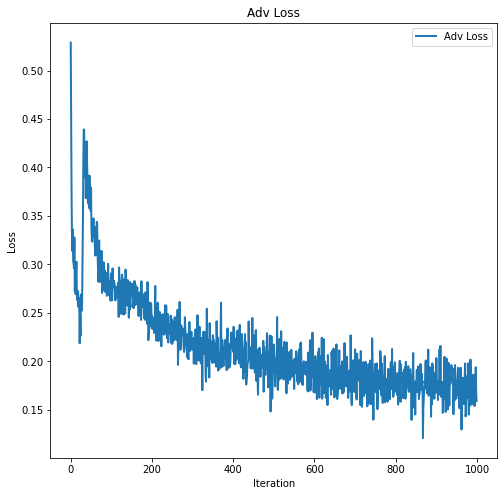

In [36]:
## Loss 
plt.figure()
plt.figure(figsize = (8,8))
plt.plot(range(niter),g_loss_History[:,1],lw=2,label="Adv Loss")

plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Adv Loss")
plt.savefig("/content/Image/Adv Loss for {} epoch".format(niter))

<Figure size 432x288 with 0 Axes>

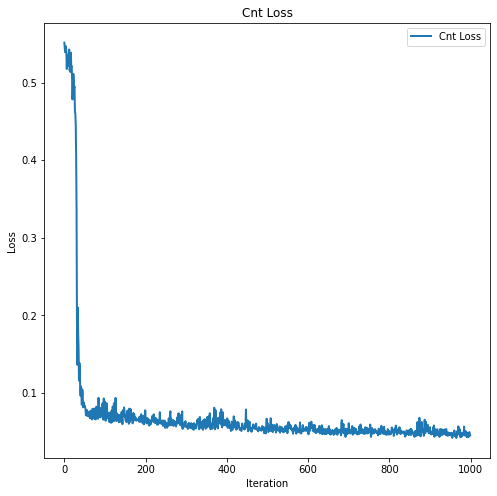

In [37]:
plt.figure()
plt.figure(figsize = (8,8))

plt.plot(range(niter),g_loss_History[:,2],lw=2,label="Cnt Loss")

plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Cnt Loss")
plt.savefig("/content/Image/Cnt Loss for {} epoch".format(niter))

<Figure size 432x288 with 0 Axes>

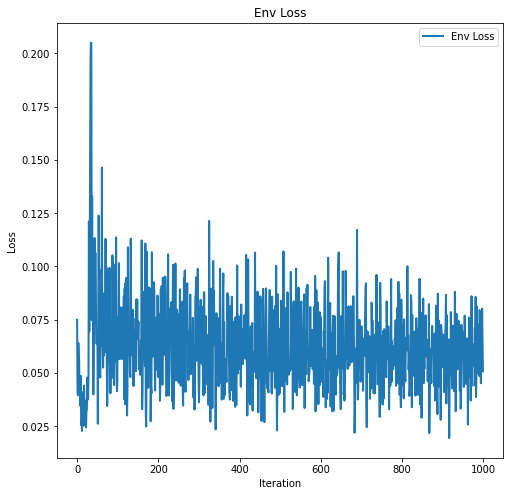

In [38]:
plt.figure()
plt.figure(figsize = (8,8))

plt.plot(range(niter),g_loss_History[:,3],lw=2,label="Env Loss")

plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Env Loss")
plt.savefig("/content/Image/Env Loss for {} epoch".format(niter))

<Figure size 432x288 with 0 Axes>

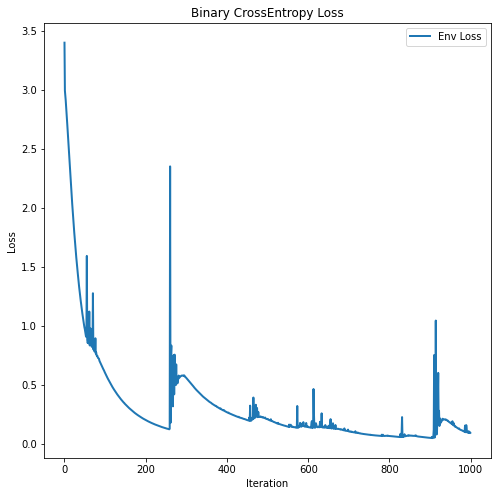

In [40]:
plt.figure()
plt.figure(figsize = (8,8))

plt.plot(range(niter),d_loss_History,lw=2,label="Env Loss")

plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Binary CrossEntropy Loss")
plt.savefig("/content/Image/Binary CrossEntropy Loss for {} epoch".format(niter))

In [73]:

## Discriminator
gan_true = g.predict(Dataset)
disr_true = d.predict(gan_true)
d_org_true = d.predict(Dataset)
# l2_true = np.abs((disr_true-d_org_true))
# l2_true = (l2_true - np.min(l2_true))/(np.max(l2_true)-np.min(l2_true))
d_true = d.predict(np.concatenate([Dataset,gan_true],axis=-1))

disr = d.predict(gan_x)
d_org = d.predict(test_img)
# l2 = np.abs((disr-d_org))
# l2 = (l2 - np.min(l2))/(np.max(l2)-np.min(l2))

d_true = d.predict(np.concatenate([test_img,gan_x],axis=-1))

In [77]:
d_true = d.predict(np.concatenate([Dataset,gan_true],axis=0))
d_abnromal = d.predict(np.concatenate([test_img,gan_x],axis=0))

In [87]:
d(Dataset[0:1,:,:,:])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>

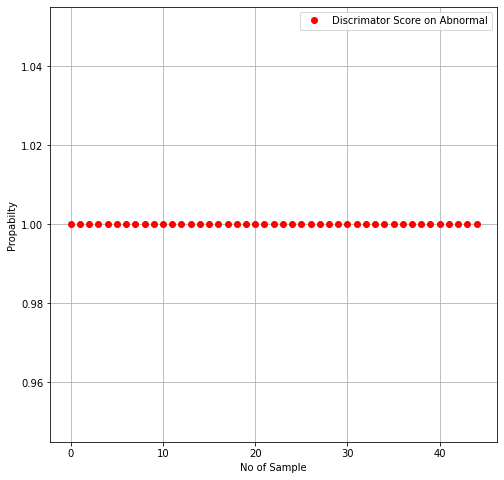

In [81]:
plt.figure(figsize=(8,8))
plt.plot(range(len(test_img)),disr,"ro",lw = 1.5,label="Discrimator Score on Abnormal")
# plt.plot(range(len(Dataset)),disr_true,"bs",lw=1.5,label="Discrimator Score on Normal")
plt.legend()
plt.grid()
plt.xlabel("No of Sample")
plt.ylabel("Propabilty")
plt.savefig("/content/Image/Discrimator Result for {}epoch".format(niter))

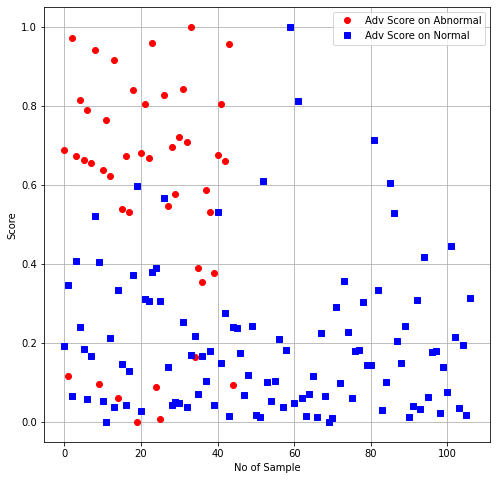

In [54]:
plt.figure(figsize=(8,8))
plt.plot(range(len(test_img)),score,"ro",lw = 1.5,label="Adv Score on Abnormal")
plt.plot(range(len(Dataset)),score_true,"bs",lw=1.5,label="Adv Score on Normal")
plt.legend()
plt.grid()
plt.xlabel("No of Sample")
plt.ylabel("Score")
plt.savefig("/content/Image/Adv Result for {}epoch".format(niter))

In [48]:
g.save(r"/content/Model/GAN.h5")
g.save_weights(r"/content/Model/GAN_weights.h5")


g_e.save(r"/content/Model/GAN_Encoder.h5")
g_e.save_weights(r"/content/Model/GAN_Encoder_weights.h5")

d.save(r"/content/Model/Discriminator.h5")
d.save_weights(r"/content/Model/Discriminator_weights.h5")

In [49]:
g.save(r"/content/Model1/GAN")
g.save_weights(r"/content/Model1/GAN_weights")


g_e.save(r"/content/Model1/GAN_Encoder")
g_e.save_weights(r"/content/Model1/GAN_Encoder_weights")

d.save(r"/content/Model1/Discriminator")
d.save_weights(r"/content/Model1/Discriminator_weights")

In [88]:
feature_extractor